In [89]:
import os
import time
import warnings
import numpy as np
import matplotlib.pyplot as plt
from math import sqrt
from numpy import newaxis, concatenate
#from numpy import *
from keras.layers.core import Dense, Activation, Dropout
from keras.layers.recurrent import LSTM
from sklearn.metrics import mean_squared_error
from pandas import read_csv, DataFrame,concat
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from keras.models import Sequential

In [90]:
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = DataFrame(data)
    cols, names = list(),list()
    for i in range(n_in, 0 ,-1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1,i)) for j in range(n_vars)]
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    agg = concat(cols, axis =1)
    agg.columns = names
    if dropnan:
        agg.dropna(inplace = True)
    return agg

def plot_results(predicted_data, true_data):
    fig = plt.figure(facecolor='white')
    ax = fig.add_subplot(111)
    ax.plot(true_data, label='True Data')
    plt.plot(predicted_data, label='Prediction')
    plt.legend()
    plt.show()

In [91]:
dataset = read_csv('fai1.csv', header = 0, index_col=0)
dataset_stock = read_csv('stock1.csv', header = 0, index_col=0)
values = dataset.values
values_stock = dataset_stock.values
encoder = LabelEncoder()
values[:,0] = encoder.fit_transform(values[:,0])
values_stock[:,0] = encoder.fit_transform(values_stock[:,0])
values = values.astype('float32')
values_stock = values_stock.astype('float32')
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)
scaled_stock = scaler.fit_transform(values_stock)
reframed = series_to_supervised(scaled, 1, 1)
reframed_stock = series_to_supervised(scaled_stock, 1, 1)
print(reframed.head())
print(reframed_stock.head())

   var1(t-1)   var1(t)
1   0.182609  0.191304
2   0.191304  0.182609
3   0.182609  0.191304
4   0.191304  0.182609
5   0.182609  0.104348
   var1(t-1)   var1(t)
1   0.157798  0.161468
2   0.161468  0.150459
3   0.150459  0.177982
4   0.177982  0.166972
5   0.166972  0.179817


In [92]:
values = reframed.values
values_stock = reframed_stock.values
n_train_hours = 673
n_end = n_train_hours + 5
train = values[:n_train_hours, :]
train_stock = values_stock[:n_train_hours,:]
test = values[n_train_hours:n_end :]
test_stock = values_stock[n_train_hours:n_end:]
train_X, train_y = train[:,:-1], train[:, -1]
train_stock_X, train_stock_y = train_stock[:,:-1], train_stock[:, -1]
test_X, test_y = test[:, :-1], test[:,-1]
test_stock_X, test_stock_y = test_stock[:, :-1], test_stock[:,-1] 
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
train_stock_X = train_stock_X.reshape((train_stock_X.shape[0], 1, train_stock_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
test_stock_X = test_stock_X.reshape((test_stock_X.shape[0], 1, test_stock_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)
print(train_stock_X.shape, train_stock_y.shape, test_stock_X.shape, test_stock_y.shape)

((673, 1, 1), (673,), (5, 1, 1), (5,))
((673, 1, 1), (673,), (5, 1, 1), (5,))


In [93]:
model = Sequential()
model.add(LSTM(20, input_shape=(train_X.shape[1], train_X.shape[2]),return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(100,return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(1))
model.add(Activation("linear"))
start = time.time()
model.add(Dense(1))
model.compile(loss='mse', optimizer='rmsprop')
print("> Compilation Time :", time.time() - start)
history = model.fit(train_X, train_y, epochs=50, batch_size=1, validation_data=(test_X, test_y), verbose=2, shuffle=False)


('> Compilation Time :', 0.02461099624633789)
Train on 673 samples, validate on 5 samples
Epoch 1/50
4s - loss: 0.0255 - val_loss: 0.0011
Epoch 2/50
2s - loss: 0.0211 - val_loss: 3.6379e-04
Epoch 3/50
2s - loss: 0.0211 - val_loss: 4.0246e-04
Epoch 4/50
2s - loss: 0.0207 - val_loss: 0.0015
Epoch 5/50
2s - loss: 0.0201 - val_loss: 0.0031
Epoch 6/50
2s - loss: 0.0205 - val_loss: 3.1852e-04
Epoch 7/50
2s - loss: 0.0191 - val_loss: 0.0015
Epoch 8/50
2s - loss: 0.0194 - val_loss: 0.0020
Epoch 9/50
2s - loss: 0.0189 - val_loss: 0.0018
Epoch 10/50
2s - loss: 0.0190 - val_loss: 0.0014
Epoch 11/50
2s - loss: 0.0190 - val_loss: 8.7596e-04
Epoch 12/50
2s - loss: 0.0191 - val_loss: 0.0014
Epoch 13/50
2s - loss: 0.0186 - val_loss: 0.0029
Epoch 14/50
2s - loss: 0.0192 - val_loss: 0.0013
Epoch 15/50
2s - loss: 0.0190 - val_loss: 0.0012
Epoch 16/50
2s - loss: 0.0194 - val_loss: 5.8707e-05
Epoch 17/50
2s - loss: 0.0193 - val_loss: 6.3068e-04
Epoch 18/50
2s - loss: 0.0189 - val_loss: 5.5962e-04
Epoch 19/

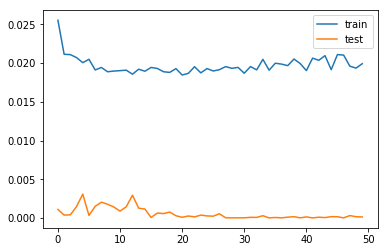

In [94]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

In [95]:
yhat =  model.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], test_X.shape[2]))
print yhat
inv_yhat = concatenate((yhat, test_X[:,1:]), axis=1)

#inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]
print inv_yhat

test_y = test_y.reshape((len(test_y), 1))
inv_y = concatenate((test_y, test_X[:, 1:]), axis =1)
#inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]
print inv_y

[[ 0.5713762]
 [ 0.5713762]
 [ 0.5713762]
 [ 0.5713762]
 [ 0.5713762]]
[ 0.5713762  0.5713762  0.5713762  0.5713762  0.5713762]
[ 0.58260864  0.58260864  0.58260864  0.58260864  0.58260864]


Test RMSE: 0.011


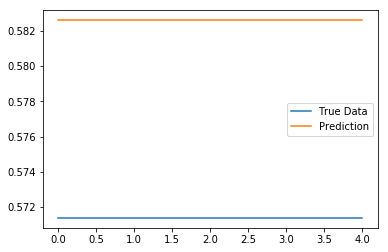

In [96]:
rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)
plot_results(inv_y, inv_yhat)

[[[ 0.56146789]]

 [[ 0.50825691]]

 [[ 0.51009172]]

 [[ 0.50091743]]

 [[ 0.48440367]]]
[ 0.50825691  0.51009172  0.50091743  0.48440367  0.49541286]
[ 0.50825691  0.51009172  0.50091743  0.48440367  0.49541286] [ 0.5713762  0.5713762  0.5713762  0.5713762  0.5713762]
Test RMSE: 0.072


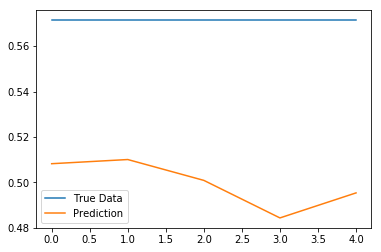

In [97]:
#print test_stock_X
test_stock_X = test_stock_X.reshape((test_stock_X.shape[0], test_stock_X.shape[2]))
test_stock_y = test_stock_y.reshape((len(test_stock_y), 1))
stock_y = concatenate((test_stock_y, test_stock_X[:, 1:]), axis =1)
stock_y = stock_y[:,0]
#print stock_y
#stock_y = stock_y * 0.002
print stock_y, inv_yhat
rmse = sqrt(mean_squared_error(stock_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)
plot_results(stock_y, inv_yhat)